In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, 
    confusion_matrix,
    roc_curve, 
    auc
)

import numpy as np
from tqdm import tqdm
import os


In [2]:
data_dir = "data_raw"

dataset = datasets.ImageFolder(data_dir)

total = len(dataset)
train_size = int(0.7 * total)
val_size = int(0.15 * total)
test_size = total - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_size, val_size, test_size


(12626, 2705, 2707)

In [3]:
train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_ds.dataset.transform = train_tf
val_ds.dataset.transform = test_tf
test_ds.dataset.transform = test_tf


In [4]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = dataset.classes
classes


['cloudy', 'foggy', 'rainy', 'snowy', 'sunny']

In [5]:
model = models.resnet50(pretrained=True)

# freeze layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer
model.fc = nn.Linear(model.fc.in_features, len(classes))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


c:\Users\Abdel\Downloads\weather_dl_project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Abdel\Downloads\weather_dl_project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Abdel/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:30<00:00, 3.38MB/s]


In [6]:
epochs = 10
train_losses, val_losses = [], []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    correct = 0
    val_loss = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

    val_accuracy = correct / len(val_ds)
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accuracy:.4f}")


100%|██████████| 395/395 [19:54<00:00,  3.03s/it]


Epoch [1/10] | Train Loss: 0.7888 | Val Loss: 0.5927 | Val Acc: 0.7723


100%|██████████| 395/395 [18:03<00:00,  2.74s/it]


Epoch [2/10] | Train Loss: 0.6013 | Val Loss: 0.5305 | Val Acc: 0.7867


100%|██████████| 395/395 [15:50<00:00,  2.41s/it]


Epoch [3/10] | Train Loss: 0.5585 | Val Loss: 0.5007 | Val Acc: 0.8004


100%|██████████| 395/395 [28:37<00:00,  4.35s/it]   


Epoch [4/10] | Train Loss: 0.5299 | Val Loss: 0.5320 | Val Acc: 0.7985


100%|██████████| 395/395 [15:53<00:00,  2.41s/it]


Epoch [5/10] | Train Loss: 0.5162 | Val Loss: 0.4695 | Val Acc: 0.8222


100%|██████████| 395/395 [36:11<00:00,  5.50s/it]    


Epoch [6/10] | Train Loss: 0.4887 | Val Loss: 0.4862 | Val Acc: 0.8100


100%|██████████| 395/395 [16:09<00:00,  2.45s/it]


Epoch [7/10] | Train Loss: 0.4825 | Val Loss: 0.4765 | Val Acc: 0.8189


100%|██████████| 395/395 [16:15<00:00,  2.47s/it]


Epoch [8/10] | Train Loss: 0.4610 | Val Loss: 0.5147 | Val Acc: 0.7963


100%|██████████| 395/395 [15:49<00:00,  2.40s/it]


Epoch [9/10] | Train Loss: 0.4564 | Val Loss: 0.4537 | Val Acc: 0.8251


100%|██████████| 395/395 [24:55<00:00,  3.79s/it]   


Epoch [10/10] | Train Loss: 0.4606 | Val Loss: 0.4695 | Val Acc: 0.8148


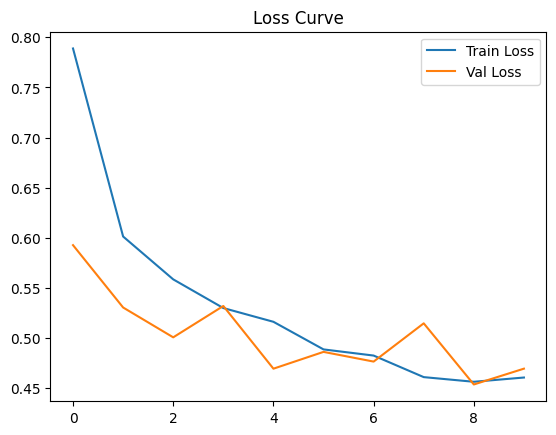

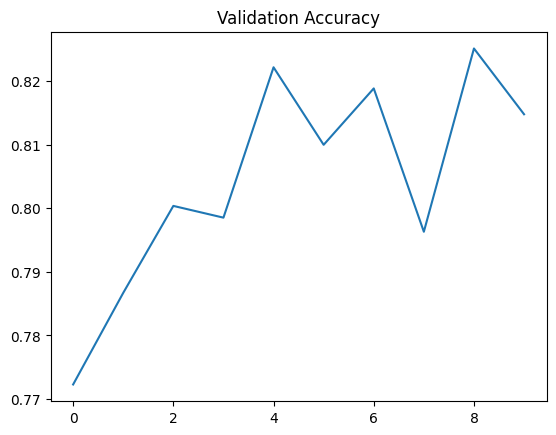

In [7]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.plot(val_accuracies)
plt.title("Validation Accuracy")
plt.show()


In [8]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=classes))


              precision    recall  f1-score   support

      cloudy       0.73      0.91      0.81       967
       foggy       0.74      0.87      0.80       190
       rainy       0.89      0.61      0.72       273
       snowy       0.85      0.81      0.83       294
       sunny       0.92      0.77      0.84       983

    accuracy                           0.81      2707
   macro avg       0.83      0.79      0.80      2707
weighted avg       0.83      0.81      0.81      2707



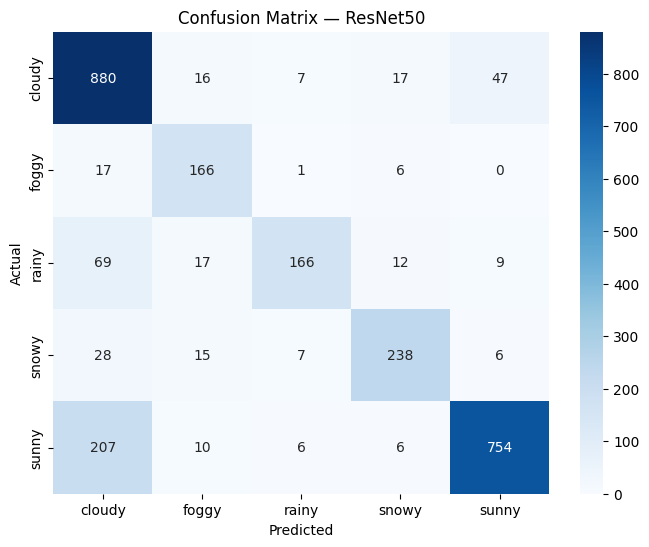

In [9]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — ResNet50")
plt.show()


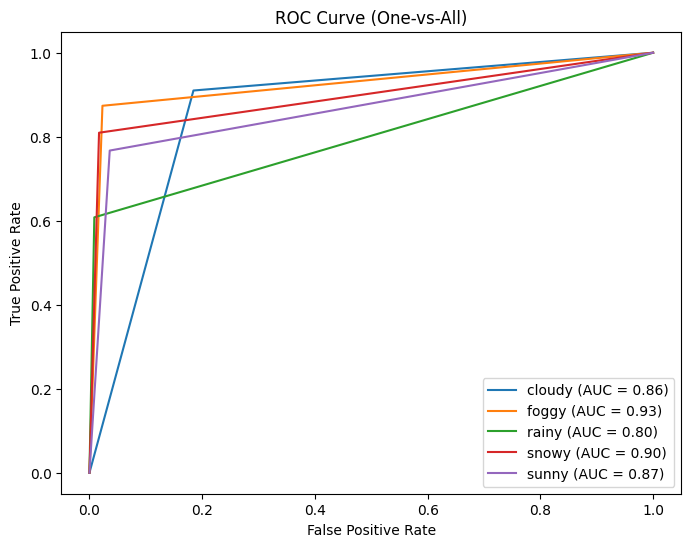

In [10]:
y_true_np = np.array(y_true)
y_pred_np = np.array(y_pred)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_np == i, y_pred_np == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f"{classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-All)")
plt.show()


In [11]:
torch.save(model.state_dict(), "resnet50_weather.pth")
print("Model saved!")


Model saved!
